In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kurtosis, skew
from scipy.stats import gaussian_kde
from math import sqrt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models import vgg16 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import os
import time
import copy
import random

In [2]:
images = [ f for f in os.listdir("assets/cats/") if os.path.isfile(os.path.join("assets/cats/", f)) ] + [ f for f in os.listdir("assets/dogs/") if os.path.isfile(os.path.join("assets/dogs/", f)) ]

len(images)

2000

In [3]:
# Load the images
from PIL import Image
import os

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

cats = load_images("assets/cats")
dogs = load_images("assets/dogs")

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Prepare dataset
def prepare_dataset(images, label):
    dataset = []
    for img in images:
        dataset.append([img, label])
    return dataset

cats_dataset = prepare_dataset(cats, 0)
dogs_dataset = prepare_dataset(dogs, 1)
dataset = cats_dataset + dogs_dataset
transformed_dataset = []
for img, label in dataset:
    transformed_dataset.append([transform(img), label])

# sample of 100 images 
sample = random.sample(transformed_dataset, 100)
sample_size = len(sample)

# Split the dataset
random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_dataset = transformed_dataset[:split]
test_dataset = transformed_dataset[split:]

In [6]:
trainloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)
sampleloader = DataLoader(sample, batch_size = sample_size, shuffle = True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = vgg16(pretrained=True)
model.to(device)

model.classifier[6].out_features = 2

for param in model.features.parameters():
    param.requires_grad = False

print(model)

/home/lonewolf/projects/dl-tl-labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lonewolf/projects/dl-tl-labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
#trainset = torchvision.datasets.CIFAR10(root='assets', train=True, download=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
#testset = torchvision.datasets.CIFAR10(root='assets', train=False, download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    return train_loss, train_accuracy

def predict(model, data):
    model.eval()
    for i, data in enumerate(data):
        data = data[0].to(device)
        output = model(data)
        _, preds = torch.max(output.data, 1)
    return preds

In [10]:
predictions = predict(model, sampleloader)

print(predictions)

tensor([285, 253, 285, 227, 208, 166, 229, 253, 283, 162, 285, 238, 209, 250,
        287, 166, 285, 205, 279, 223, 262, 204, 285, 158, 285, 285, 861, 245,
        178, 166, 203, 478, 227, 179, 159, 333, 154, 520, 281, 171, 284, 283,
        285, 179, 680, 180, 166, 285, 346, 171, 285, 231, 281, 281, 180, 260,
        182, 260, 281, 208, 176, 222, 285, 166, 249, 208, 284, 158, 227, 227,
        285, 208, 199, 223, 332, 281, 285, 283, 285, 259, 285, 728, 281, 174,
        215, 453, 223, 166, 281, 246, 285, 281, 332, 281, 281, 178, 208, 258,
        285, 539])


In [11]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    print(f'Epoch {epoch+1} | Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f} | Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_accuracy:.2f}')
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

Epoch 1 | Train Loss: 0.0701, Train Acc: 75.00 | Validation Loss: 0.0104, Validation Acc: 89.75
Epoch 2 | Train Loss: 0.0027, Train Acc: 96.94 | Validation Loss: 0.0080, Validation Acc: 91.75
Epoch 3 | Train Loss: 0.0016, Train Acc: 98.38 | Validation Loss: 0.0041, Validation Acc: 94.75
Epoch 4 | Train Loss: 0.0010, Train Acc: 99.06 | Validation Loss: 0.0051, Validation Acc: 94.25
Epoch 5 | Train Loss: 0.0009, Train Acc: 99.12 | Validation Loss: 0.0042, Validation Acc: 94.25
Epoch 6 | Train Loss: 0.0008, Train Acc: 99.19 | Validation Loss: 0.0060, Validation Acc: 93.75
Epoch 7 | Train Loss: 0.0005, Train Acc: 99.69 | Validation Loss: 0.0064, Validation Acc: 93.50
Epoch 8 | Train Loss: 0.0005, Train Acc: 99.69 | Validation Loss: 0.0052, Validation Acc: 94.25
Epoch 9 | Train Loss: 0.0004, Train Acc: 99.62 | Validation Loss: 0.0061, Validation Acc: 94.00
Epoch 10 | Train Loss: 0.0003, Train Acc: 99.69 | Validation Loss: 0.0055, Validation Acc: 94.00
44.32512920300166 minutes


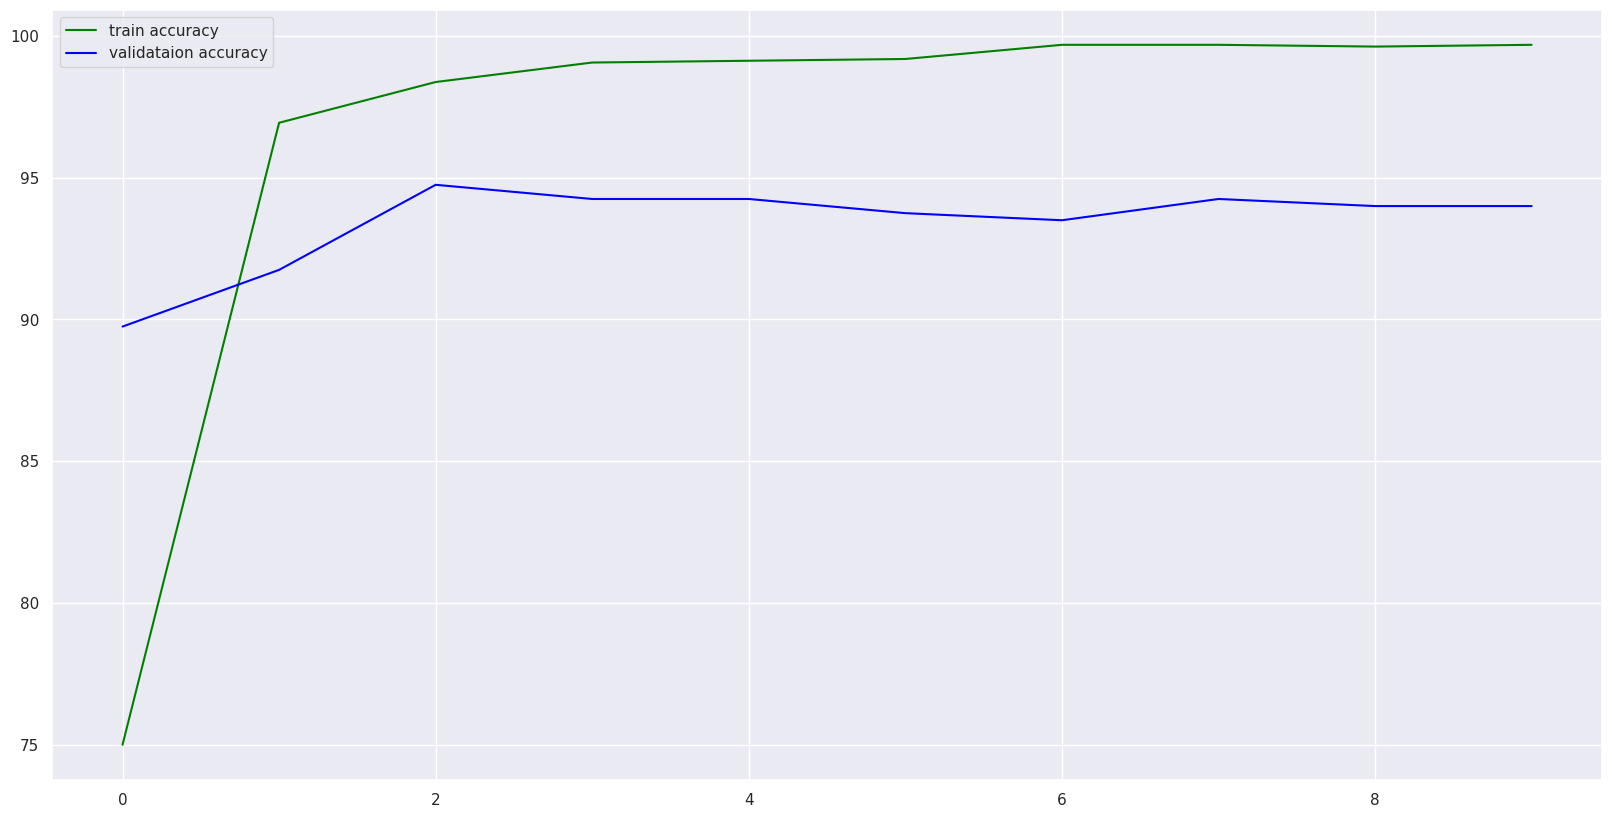

In [12]:
sns.set(rc={'figure.figsize':(20, 10)})
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

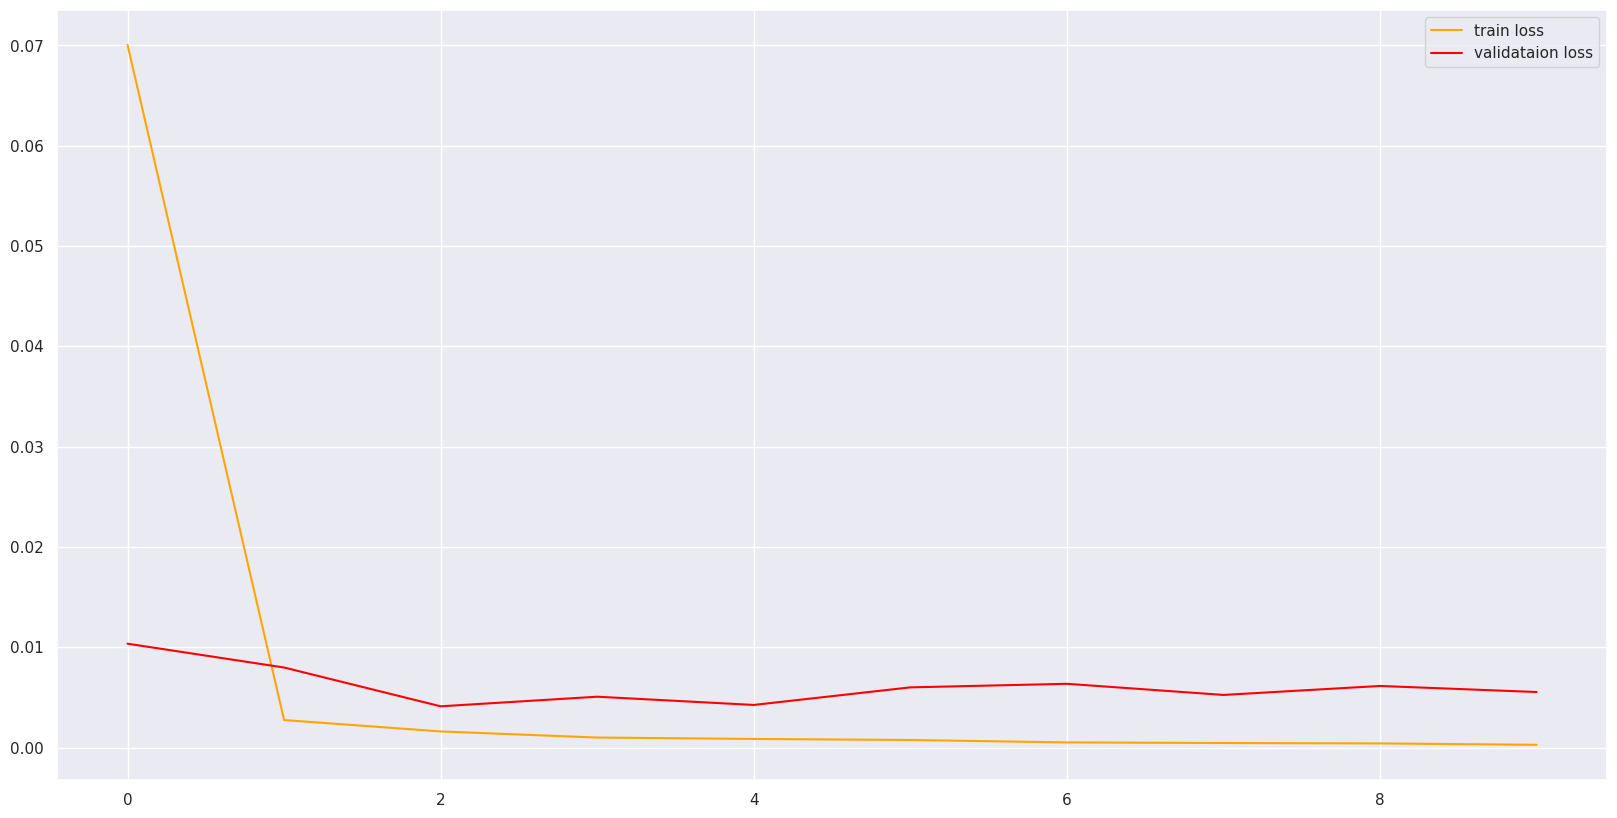

In [13]:
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()